# Engineering Location Features with Haversine's Formula for Prediction Modeling

So you'd like to build a prediction model from some data, but some of the columns seem a bit . . . useless? Alternatively, the column of data might accidentally infer meaning where there shouldn't be any. Let's try this out by engineering some columns with location data to help predict the price of a home using a small slice of the King County Housing Data set from Washington State. Let's explore how we can turn difficult columns into something useful instead of just throwing them away or using them incorrectly.

In [24]:
import pandas as pd

df = pd.read_csv('kc_house_data.csv')
df.head().T

,0,1,2,3,4
id,7129300520,6414100192,5631500400,2487200875,1954400510
date,10/13/2014,12/9/2014,2/25/2015,12/9/2014,2/18/2015
price,221900,538000,180000,604000,510000
bedrooms,3,3,2,4,3
bathrooms,1,2.25,1,3,2
sqft_living,1180,2570,770,1960,1680
sqft_lot,5650,7242,10000,5000,8080
floors,1,2,1,1,1
waterfront,NaN,0,0,0,0
view,0,0,0,0,0


What do each of these columns mean?

In [25]:
from IPython.display import display, Markdown

with open('column_names.md', 'r') as fh:
    content = fh.read()

display(Markdown(content))

COLUMN NAMES AND DESCRIPTIONS FOR KING COUNTRY DATA SET
* **id** - unique identified for a house
* **dateDate** - house was sold
* **pricePrice** -  is prediction target
* **bedroomsNumber** -  of Bedrooms/House
* **bathroomsNumber** -  of bathrooms/bedrooms
* **sqft_livingsquare** -  footage of the home
* **sqft_lotsquare** -  footage of the lot
* **floorsTotal** -  floors (levels) in house
* **waterfront** - House which has a view to a waterfront
* **view** - Has been viewed
* **condition** - How good the condition is ( Overall )
* **grade** - overall grade given to the housing unit, based on King County grading system
* **sqft_above** - square footage of house apart from basement
* **sqft_basement** - square footage of the basement
* **yr_built** - Built Year
* **yr_renovated** - Year when house was renovated
* **zipcode** - zip
* **lat** - Latitude coordinate
* **long** - Longitude coordinate
* **sqft_living15** - The square footage of interior housing living space for the nearest 15 neighbors
* **sqft_lot15** - The square footage of the land lots of the nearest 15 neighbors


Many of these columns seem like they should have some kind of an influence on the price. In particular, the common saying "the three most important things to think about when buying are home are location, location, location" tells us we should probably care a lot about things like zipcode, latitude, and longitude. Also, just to note, 'sqft_living15' and 'sqft_lot15' are metadata about each house in the database that someone else has already engineered for us. Thanks, King Co. data scientist!

There are plenty of columns we could use, but for this tutorial with Haversine, let's just focus on latitude & longitude. Let's get a visual of what this data looks like.

/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


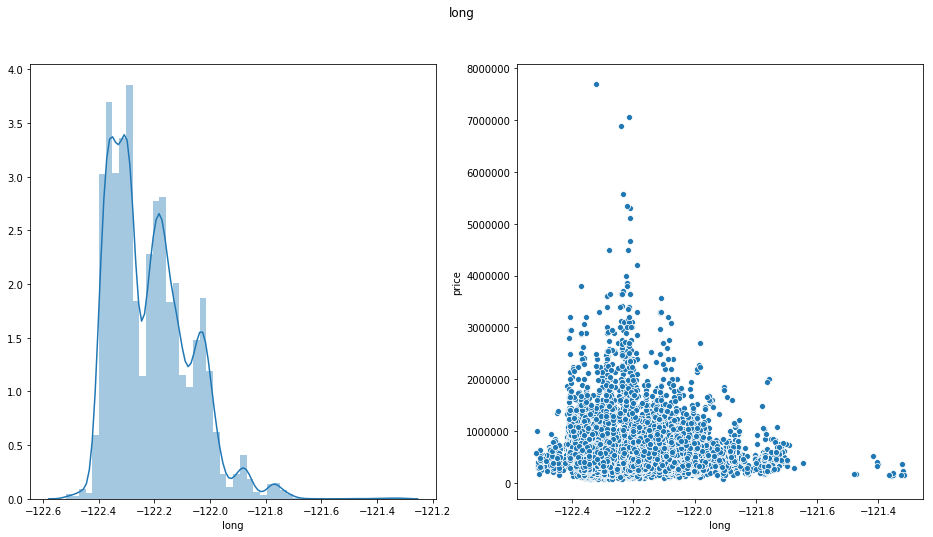

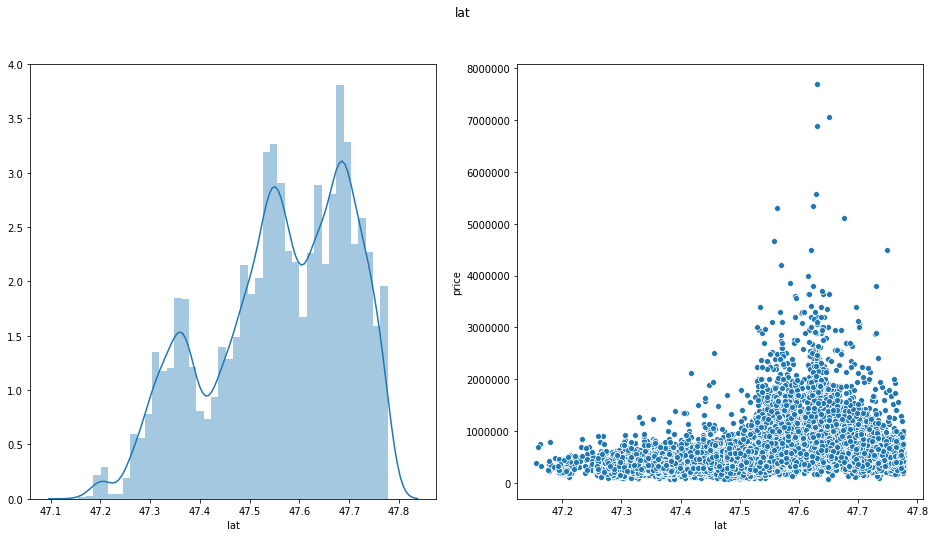

In [37]:
target = df['price'].copy()
needs_work = df[['long', 'lat']].copy()

import seaborn as sns
import matplotlib.pyplot as plt

for col in needs_work:
    x = needs_work[col]
    y = target
    
    plt.figure(figsize=(16,8))
    plt.subplot(1,2,1)
    sns.distplot(x)
    plt.subplot(1,2,2)
    
    sns.scatterplot(x, y)
    plt.suptitle(col)
    plt.tight_layout

Even though these pairs of graphs look similar, notice the y-axes on these plots are measuring different things. The histogram is simply counting how many observations of the x-value we have in the data, while the scatterplot is showing the price in USD of the house sold at the x-value. It's almost like more houses sold (histogram height) correlates rather strongly with a higher sale price (scatterplot height). The Law of Supply & Demand seems alive and well in King County, WA. We'll discuss how to deal with this data in regard to predicting sale price using Haversine's 3D distance formula.

Before we get into the details of the formula, let's talk about why we should consider augmenting the location data at all. The problem here is that ONLY looking at one-dimensional movement on a map doesn't particularly generate accurate housing price patterns. Another way of saying this is there is no linear relationship between either latitude vs price nor longitude vs price. For example, if there are multiple wealthy neighborhoods that have lower-priced neighborhoods in between them, using just that one dimension of data won't accurately predict the value. In the following image (shamelessly lifted from http://www.peteryu.ca/tutorials/matlab/image_in_3d_surface_plot_with_multiple_colormaps) imagine the Z axis isn't elevation, but rather home price. As you can see in the heatmap below the surface, there isn't a clear linear pattern when you move along JUST the X-direction or just the Y-direction, but proximity to the dark red spot near the back right part of the graph *would* have a clear pattern for predicting price.
(Note the red spot near the bottom left should actually be blue on the heatmap, as in this example, it represents very low house prices.)

![image](http://www.peteryu.ca/_media/tutorials/matlab/image_surf_3d_basic.png)

When modeling with multivariable linear regression, simply having both latitude and longitude doesn't really help either. Instead, let's think about why home values in some neighborhoods are high vs low. It could simply be the houses in those neighborhoods have a view of the mountains & water, but the only way any one home sells for a lot of money is if someone pays a lot of money for it. I know this seems simplistic, but high home values require high paying jobs, and people with high paying jobs will pay more to be conveniently close their work (especially if the home has a view of the mountains or water). This leads me to believe a "radius from high-paying job cluster" might be a much better indicator of home value instead of using the two columns of 'longitude' and 'latitude' on their own. Let's build one! In fact, if there are multiple employment clusters, maybe building a single column for each "job hub" would make sense.

If you are willing to accept that we live on a round planet, we can utilize the Haversine formula, which measures 3D arc-length on the surface of a sphere. This is really just an adaption of the Pythagorean theorem.

We adapt the python code from:  https://stackoverflow.com/questions/4913349/haversine-formula-in-python-bearing-and-distance-between-two-gps-points/4913653


We choose to pass in two arguments, each in the form `[longitude, latitude]`. To do this, we first build a new column to serve as the input to the function.

In [38]:
needs_work.head(2)

,long,lat
0,-122.257,47.5112
1,-122.319,47.7210


In [39]:
needs_work['long_lat'] = list(zip(needs_work['long'], needs_work['lat']))
needs_work.head(2)

,long,lat,long_lat
0,-122.257,47.5112,"(-122.257, 47.5112)"
1,-122.319,47.7210,"(-122.319, 47.721000000000004)"


Now we define the Haversine function. Alternatively, you can simply import it from https://pypi.org/project/haversine/ but we want to make sure we can control exactly what is going on and it's fun to see trigonometry in action!

In [30]:
from math import radians, cos, sin, asin, sqrt

def haversine(list_long_lat, other=[-122.336283, 47.609395]):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees), in this case the 2nd point is in the 
    Pike Pine Retail Core of Seattle, WA.
    """
    lon1, lat1 = list_long_lat[0], list_long_lat[1]
    lon2, lat2 = other[0], other[1]
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    # Radius of earth in kilometers is 6371
    km = 6371 * c
    return km

We're finally ready to build our useful output column using `series.apply()` which yields the distance to Seattle.

In [41]:
needs_work['dist_to_seattle'] = needs_work['long_lat'].apply(haversine)

In fact, it would very easy to build another column for a different "job cluster location" at this same point by passing in the optional arguments for haversine() doing a different `series.apply(function, opt_arg=______)`. Seattle's "suburb" of Bellevue has actually grown into its own city with skyscrapers and high paying jobs of its own. Let's create the `'dist_to_bellevue'` column as well.

In [42]:
needs_work['dist_to_bellevue'] = needs_work['long_lat'].apply(haversine, other=[-122.198985, 47.615577])

Finally, let's drop the columns we used as the building blocks for these two new columns. (Although instead of using `df.drop([columns], axis=1)` we actively select the columns to keep.)

In [44]:
engineered_columns = needs_work.loc[:,['dist_to_seattle', 'dist_to_bellevue']]

In [46]:
engineered_columns.head(10)

,dist_to_seattle,dist_to_bellevue
0,12.434278,12.395639
1,12.477217,14.770934
2,16.247460,13.838051
3,10.731122,17.970486
4,21.850148,11.542868
5,25.361129,15.217257
6,33.331870,35.347235
7,22.284717,24.515385
8,10.796605,15.463271
9,35.274167,30.244215


Now you can add these back into to your original dataframe and begin improving your model with these new feature columns.